In [1]:
import sys
import cv2
import matplotlib.pyplot as plt
import numpy as np
import math
%matplotlib inline

In [2]:
def readRGB(filename: str):
    blue, green, red = cv2.split(
        cv2.imread(filename)
    )
    return cv2.merge((red, green, blue))

def readGRAY(filename: str):
    return cv2.cvtColor(
        readRGB(filename), 
        cv2.COLOR_BGR2GRAY
    )

def readBIN(filename: str, min, max):
    return cv2.threshold(
        readGRAY(filename),
        float(min), 
        float(max),
        cv2.THRESH_BINARY_INV
    )[1]
    

def show(pic):
    cv2.imshow("test", pic)
    cv2.waitKey()
    cv2.destroyAllWindows()
    
def show_gray(pic):
    plt.imshow(pic, cmap = 'gray')

def show_diff(pic_1, pic_2, msg = "Original", msg_2 = "Processed"):
    plt.subplot(121)
    plt.imshow(pic_1, cmap = 'gray')
    plt.xticks([])  # 去掉x轴
    plt.yticks([])  # 去掉y轴
    plt.axis('off')  # 去掉坐标轴
    plt.title(msg)
    plt.subplot(122)
    plt.imshow(pic_2, cmap = 'gray')
    plt.xticks([])  # 去掉x轴
    plt.yticks([])  # 去掉y轴
    plt.axis('off')  # 去掉坐标轴
    plt.title(msg_2)

(-0.5, 511.5, 511.5, -0.5)

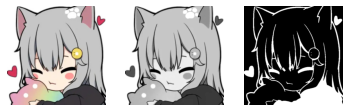

In [3]:
pic = readRGB('test.jpeg')
pic_gray = readGRAY('test.jpeg')
pic_binary = readBIN('test.jpeg', 125, 255)

plt.subplot(131)
plt.imshow(pic)
plt.xticks([])  # 去掉x轴
plt.yticks([])  # 去掉y轴
plt.axis('off')  # 去掉坐标轴

plt.subplot(132)
show_gray(pic_gray)
plt.xticks([])  # 去掉x轴
plt.yticks([])  # 去掉y轴
plt.axis('off')  # 去掉坐标轴

plt.subplot(133)
show_gray(pic_binary)
plt.xticks([])  # 去掉x轴
plt.yticks([])  # 去掉y轴
plt.axis('off')  # 去掉坐标轴

(-0.5, 1475.5, 1133.5, -0.5)

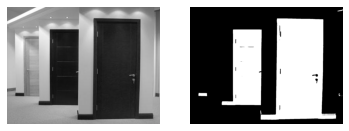

In [4]:
plt.subplot(121)
door = readRGB('data/01_door.png')
show_gray(door)
plt.xticks([])  # 去掉x轴
plt.yticks([])  # 去掉y轴
plt.axis('off')  # 去掉坐标轴

plt.subplot(122)
door_b = readBIN('data/01_door.png', 65, 255)
show_gray(door_b)
plt.xticks([])  # 去掉x轴
plt.yticks([])  # 去掉y轴
plt.axis('off')  # 去掉坐标轴

# 阈值操作
## `one-sided`
$$
F_T[i,\,j]=1,\,if\,F[i,j]\geq T
$$

In [5]:
pic_gray

array([[255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       ...,
       [255, 255, 255, ...,   1,   8,  51],
       [255, 255, 255, ...,   1,   7,  32],
       [255, 255, 255, ...,   1,   8,  27]], dtype=uint8)

In [6]:
x = np.arange(1, 256)
y = np.arange(1, 256)
for i in range(255):
    y[i] = 0
for i in range(col):
    for j in range(row):
        y[pic_gray[i][j] - 1] += 1

NameError: name 'col' is not defined

(0.0, 5000.0)

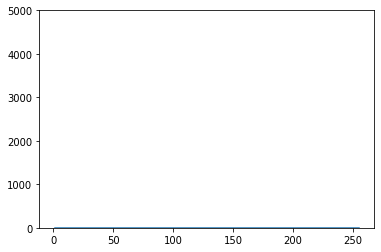

In [7]:
plt.plot(x, y)
plt.ylim(0, 5000)

## Global Binarization [Ohta' 79]

In [10]:
def draw_hist(pic):
    row, col = pic.shape
    x = np.arange(1, 256)
    y = np.arange(1, 256)
    for i in range(255):
        y[i] = 0
    for i in range(row):
        for j in range(col):
            y[pic[i][j] - 1] += 1
    plt.plot(x, y)
    plt.ylim(0, 300)
    plt.xlim(0, 255)

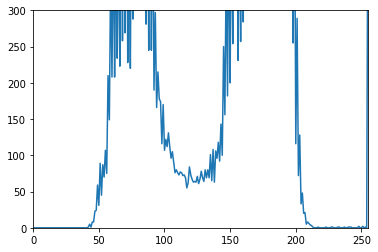

In [11]:
phone = readGRAY('data/01_phone.png')
draw_hist(phone)

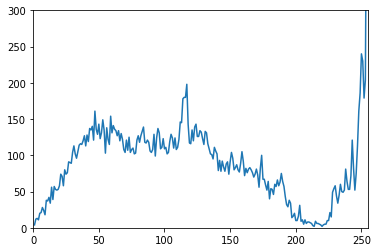

In [12]:
house = readGRAY('data/01_house.png')
draw_hist(house)

In [13]:
def cal(pic, T):
    row, col = pic.shape
    high = low = 0
    n_high = n_low = 0
    # 遍历图像，大于阈值者，计算像素值和、计数值增一
    for i in range (row):
        for j in range (col):
            if pic[i, j] > T:
                high += pic[i, j]
                n_high += 1
            else:
                low += pic[i, j]
                n_low += 1
    # 平均像素灰度值，像素和 / 计数
    m1 = int(high / n_high)
    m2 = int(low / n_low)   
    return int((m1 + m2) / 2)   # 据公式计算新的阈值

In [14]:
def ohta(img, T, mode:int):
    # 两种模式：mode == 1时，大于阈值部分置黑
    row, col = img.shape
    img1 = np.zeros((row, col), np.uint8)
    T0 = T
    T1 = cal(img, T0)
    for k in range (100):   # 迭代次数为经验值，可据实际情况选定
        print("This is ", k, " times iteration. T = ", T1)
        if abs(T1 - T0) == 0:   # 若新阈值减旧阈值差值为零，则为二值图最佳阈值
            for i in range (row):
                for j in range (col):
                    if img[i, j] > T1:
                        if mode == 1:
                            img1[i, j] = 0
                        else:
                            img1[i, j] = 255
                    else:
                        if mode == 1:
                            img1[i, j] = 255
                        else:
                            img1[i, j] = 0
            break
        else:
            T2 = cal(img, T1)
            T0 = T1
            T1 = T2   # 变量转换，保证if条件为新阈值减旧阈值
    return img1

This is  0  times iteration. T =  128
This is  1  times iteration. T =  128
[[255 255 255 ...   0   0 255]
 [255 255 255 ...   0   0 255]
 [255 255 255 ...   0   0 255]
 ...
 [255   0   0 ...   0   0 255]
 [255   0   0 ...   0   0 255]
 [255   0   0 ...   0   0 255]]


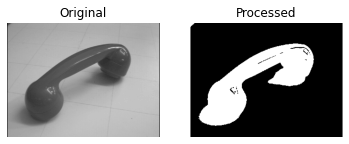

In [15]:
T = ohta(phone, 127, 1)
print(T)
show_diff(phone, T)

This is  0  times iteration. T =  142
This is  1  times iteration. T =  150
This is  2  times iteration. T =  154
This is  3  times iteration. T =  156
This is  4  times iteration. T =  157
This is  5  times iteration. T =  158
This is  6  times iteration. T =  158
[[255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 ...
 [  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]]


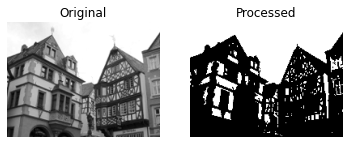

In [16]:
T = ohta(house, 127, 0)
print(T)
show_diff(house, T)

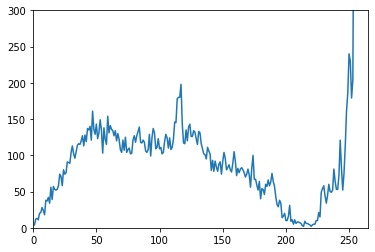

In [24]:
def draw_hist(pic):
    row, col = pic.shape
    x = np.arange(1, 256)
    y = np.arange(1, 256)
    for i in range(255):
        y[i] = 0
    for i in range(row):
        for j in range(col):
            y[pic[i][j] - 1] += 1
    plt.plot(x, y)
    plt.ylim(0, 300)
    plt.xlim(0, 265)
draw_hist(house)

This is  0  times iteration. T =  114
This is  1  times iteration. T =  109
This is  2  times iteration. T =  106
This is  3  times iteration. T =  105
This is  4  times iteration. T =  104
This is  5  times iteration. T =  104
[[  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]
 ...
 [255 255 255 ...   0   0   0]
 [255 255 255 ...   0   0   0]
 [255 255 255 ...   0   0   0]]


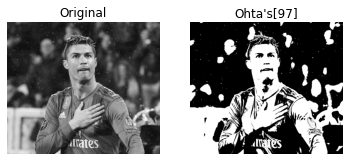

In [17]:
cr = readGRAY('data/01_cr.png')
T = ohta(cr, 127, 0)
print(T)
show_diff(cr, T, msg_2 = "Ohta's[97]")

(3000,)


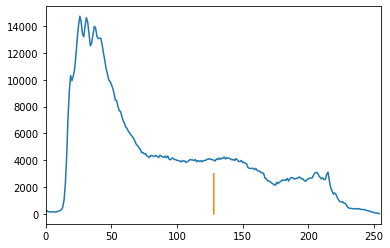

In [41]:
def draw_hist(pic):
    y = np.zeros((255, ))
    x = np.repeat(128, 3000)
    temp = np.arange(0, 3000)
    print(x.shape)
    for i in range(pic.shape[0]):
        for j in range(pic.shape[1]):
            y[pic.item(i, j) - 1] += 1
    
    plt.xlim(0, 255)
    plt.plot(y)
    plt.plot(x, temp)
draw_hist(cr)

(3000,)


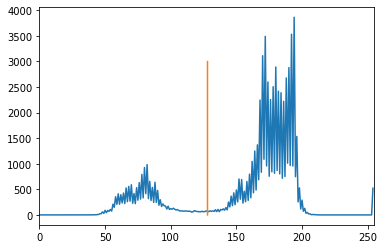

In [42]:
phone = readGRAY('data/01_phone.png')
draw_hist(phone)

In [ ]:
show_diff(
    (cv2.threshold(cr, 127, 255, cv2.THRESH_BINARY))[1], 
    (cv2.threshold(cr, 127, 255, cv2.THRESH_OTSU))[1],
    "THRESH_BINARY",
    "THRESH_OTSU"
)

# Local Binarization [Niblack'86]
通过一个小滑窗`W`估计局部阈值
$$
T_w = \mu_W + k\dot \sigma_W\,\,,k\in[-10,\,0]\,user\,defined
$$


改进的版本可抑制文档二值化的背景噪音[Sauvola'00]
$$
T_W=\mu_W[1+k\dot(\frac{\sigma_W}{R}-1)]
$$
R
Sauvola算法的输入是灰度图像，它以当前像素点为中心，根据当前像素点邻域内的灰度均值与标准方差来动态计算该像素点的阈值。

假定当前像素点的坐标为(x,y)，以该点为中心的领域为r*r，g(x,y)表示(x,y)处的灰度值，Sauvola算法的步骤为：

In [43]:
def window(gray, i, j, win = (5, 5), k = 0.5):
    row, col = gray.shape
    # print(row, "rows,", col, "cols.")
    
    if i >= row or j >= col:
        # print("Error Value")
        return
    wid = (int)(win[0] / 2)
    len = (int)(win[1] / 2)
    
    from_r = (i - wid) if (i - wid) >= 0 else 0
    to_r = (i + wid) if (i + wid) < (row - 1) else (row - 1)
    from_c = (j - len) if (j - len) >= 0 else 0
    to_c = (j + len) if (j + len) < (col - 1) else (col - 1)
    
    wid = to_r - from_r + 1
    len = to_c - from_c + 1
    
    temp = wid * len
    
    mean = 0
    for i in range(from_r, to_r + 1):
        for j in range(from_c, to_c + 1):
            # print(" i, j", i, j)
            mean += gray[i][j]
    mean /= temp
    # print("       mean", mean)
    s = 0
    count = 0
    for i in range(from_r, to_r + 1):
        for j in range(from_c, to_c + 1):
            count += 1
            s += math.pow(gray[i][j] - mean, 2)
            # print(".      i,j,g[][],m", i, j, gray[i][j], mean)
    s = math.sqrt(s / temp)
    # print(".      s", s)
    # print("       s", s)
    # print(count, temp)
    return mean + k * s

In [ ]:
def window(gray, i, j, win = (5, 5), k = 0.5):
    row, col = gray.shape
    if i >= row or j >= col:
        # print("Error Value")
        return
    wid = (int)(win[0] / 2)
    len = (int)(win[1] / 2)
    
    from_r = (i - wid) if (i - wid) >= 0        else 0
    to_r   = (i + wid) if (i + wid) < (row - 1) else (row - 1)
    from_c = (j - len) if (j - len) >= 0        else 0
    to_c   = (j + len) if (j + len) < (col - 1) else (col - 1)
    
    wid = to_r - from_r + 1
    len = to_c - from_c + 1
    
    gray_sli = gray[from_r : to_r, from_c : to_c ]
    mean = np.avg(gray_sli)
    s = np.std(gray_sli)
    
    return mean + k * s

In [44]:
text = readGRAY('data/01_text.png')
window(text, 385, 367)
window(text, 1, 1)

106.23392364858906

In [45]:
def niblack(gray, R = 128, k = 0.5, win = (5, 5)):
    row, col = gray.shape
    img = np.zeros((row, col), np.uint8)
    
    count = 0
    
    for i in range(row - 1):
        if count == 80:
            print(i/(row - 1))
            count = 0
        count += 1
        for j in range(col):
            T = window(gray, i, j, win, k)
            if gray[i][j] > T:
                img[i][j] = 0
            else:
                img[i][j] = 255
    return img

This is  0  times iteration. T =  143
This is  1  times iteration. T =  143


(386, 368)

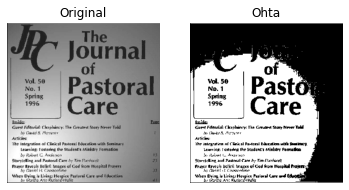

In [46]:
text = readGRAY('data/01_text.png')
show_diff(text, ohta(text, 142, 0), msg_2 = "Ohta")
text.shape

0.2077922077922078
0.4155844155844156
0.6233766233766234
0.8311688311688312
This is  0  times iteration. T =  143
This is  1  times iteration. T =  143


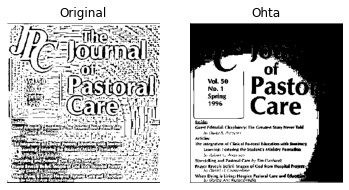

In [47]:
show_diff(
    niblack(text, R = 128, k = 0.5, win = (10, 10)),
    ohta(text, 142, 0), msg_2 = "Ohta"
)

0.08221993833504625
0.1644398766700925
0.24665981500513876
0.328879753340185
0.41109969167523125
0.4933196300102775
0.5755395683453237
0.65775950668037
0.7399794450154162
0.8221993833504625
0.9044193216855088
0.986639260020555
This is  0  times iteration. T =  122
This is  1  times iteration. T =  112
This is  2  times iteration. T =  107
This is  3  times iteration. T =  105
This is  4  times iteration. T =  104
This is  5  times iteration. T =  104


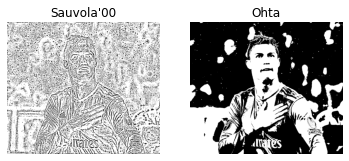

In [48]:
show_diff(
    niblack(cr, R = 128, k = 0.5, win = (10, 10)),
    ohta(cr, 142, 0), msg="Sauvola'00", msg_2 = "Ohta"
)

0.12012012012012012
0.24024024024024024
0.36036036036036034
0.4804804804804805
0.6006006006006006
0.7207207207207207
0.8408408408408409
0.960960960960961
This is  0  times iteration. T =  146
This is  1  times iteration. T =  148
This is  2  times iteration. T =  149
This is  3  times iteration. T =  150
This is  4  times iteration. T =  151
This is  5  times iteration. T =  151


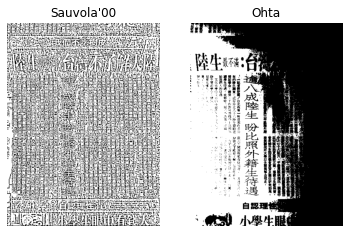

In [49]:
book = readGRAY('data/book.jpg')
show_diff(
    niblack(book, R = 128, k = 0.5, win = (7, 7)),
    ohta(book, 142, 0), msg="Sauvola'00", msg_2 = "Ohta"
)

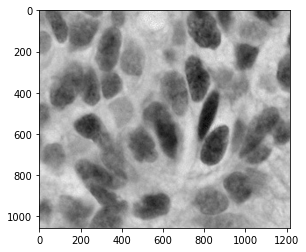

In [50]:
cell = readGRAY('data/01_cell.png')
show_gray(cell)

0.07582938388625593
0.15165876777251186
0.22748815165876776
0.3033175355450237
0.3791469194312796
0.4549763033175355
0.5308056872037915
0.6066350710900474
0.6824644549763034
0.7582938388625592
0.8341232227488151
0.909952606635071
0.985781990521327
This is  0  times iteration. T =  136
This is  1  times iteration. T =  134
This is  2  times iteration. T =  132
This is  3  times iteration. T =  131
This is  4  times iteration. T =  131


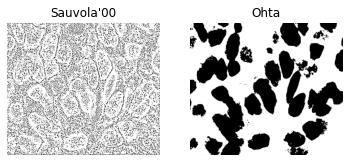

In [51]:
show_diff(
    niblack(cell, R = 128, k = 0.5, win = (10, 10)),
    ohta(cell, 142, 0), msg="Sauvola'00", msg_2 = "Ohta"
)

In [52]:
def window_2(gray, i, j, win = (5, 5), k = 0.5, R = 128):
    row, col = gray.shape
    # print(row, "rows,", col, "cols.")
    
    if i >= row or j >= col:
        # print("Error Value")
        return
    wid = (int)(win[0] / 2)
    len = (int)(win[1] / 2)
    
    from_r = (i - wid) if (i - wid) >= 0 else 0
    to_r = (i + wid) if (i + wid) < (row - 1) else (row - 1)
    from_c = (j - len) if (j - len) >= 0 else 0
    to_c = (j + len) if (j + len) < (col - 1) else (col - 1)
    
    wid = to_r - from_r + 1
    len = to_c - from_c + 1
    
    temp = wid * len
    
    mean = 0
    for i in range(from_r, to_r + 1):
        for j in range(from_c, to_c + 1):
            # print(" i, j", i, j)
            mean += gray[i][j]
    mean /= temp
    # print("       mean", mean)
    s = 0
    count = 0
    for i in range(from_r, to_r + 1):
        for j in range(from_c, to_c + 1):
            count += 1
            s += math.pow(gray[i][j] - mean, 2)
            # print(".      i,j,g[][],m", i, j, gray[i][j], mean)
    s = math.sqrt(s / temp)
    # print(".      s", s)
    # print("       s", s)
    # print(count, temp)
    return mean * (1 + k * ((s / R) - 1) )

def sauvola(gray, R = 128, k = 0.5, win = (5, 5)):
    row, col = gray.shape
    img = np.zeros((row, col), np.uint8)
    
    count = 0
    
    for i in range(row - 1):
        if count == 80:
            print(i/(row - 1))
            count = 0
        count += 1
        for j in range(col):
            T = window_2(gray, i, j, win, k)
            if gray[i][j] > T:
                img[i][j] = 0
            else:
                img[i][j] = 255
    return img

0.07582938388625593
0.15165876777251186
0.22748815165876776
0.3033175355450237
0.3791469194312796
0.4549763033175355
0.5308056872037915
0.6066350710900474
0.6824644549763034
0.7582938388625592
0.8341232227488151
0.909952606635071
0.985781990521327
0.07582938388625593
0.15165876777251186
0.22748815165876776
0.3033175355450237
0.3791469194312796
0.4549763033175355
0.5308056872037915
0.6066350710900474
0.6824644549763034
0.7582938388625592
0.8341232227488151
0.909952606635071
0.985781990521327


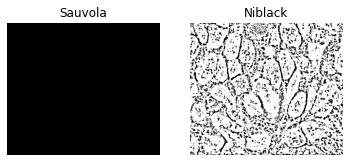

In [53]:
cell_sau = sauvola(cell, R = 128, k = 0.5, win = (31, 31))
cell_nib = niblack(cell, R = 128, k = 0.5, win = (31, 31))
show_diff(
    cell_sau,
    cell_nib, msg="Sauvola", msg_2 = "Niblack"
)

In [54]:
def integral(img):
    '''
    计算图像的积分和平方积分
    :param img:Mat--- 输入待处理图像
    :return:integral_sum, integral_sqrt_sum：Mat--- 积分图和平方积分图
    '''
    integral_sum=np.zeros((img.shape[0],img.shape[1]),dtype=np.int32)
    integral_sqrt_sum=np.zeros((img.shape[0],img.shape[1]),dtype=np.int32)
 
    rows,cols=img.shape
    for r in range(rows):
        sum=0
        sqrt_sum=0
        for c in range(cols):
            sum+=img[r][c]
            sqrt_sum+=math.sqrt(img[r][c])
 
            if r==0:
                integral_sum[r][c]=sum
                integral_sqrt_sum[r][c]=sqrt_sum
            else:
                integral_sum[r][c]=sum+integral_sum[r-1][c]
                integral_sqrt_sum[r][c]=sqrt_sum+integral_sqrt_sum[r-1][c]
 
    return integral_sum, integral_sqrt_sum
 
def test_sau(img,k=0.1,kernerl=(31,31)):
    '''
    sauvola阈值法。
    根据当前像素点邻域内的灰度均值与标准方差来动态计算该像素点的阈值
    :param img:Mat--- 输入待处理图像
    :param k:float---修正参数,一般0<k<1
    :param kernerl:set---窗口大小
    :return:img:Mat---阈值处理后的图像
    '''
    if kernerl[0]%2!=1 or kernerl[1]%2!=1:
        raise ValueError('kernerl元组中的值必须为奇数,'
                         '请检查kernerl[0] or kernerl[1]是否为奇数!!!')
 
    # 计算积分图和积分平方和图
    integral_sum,integral_sqrt_sum=integral(img)
    # integral_sum, integral_sqrt_sum = cv2.integral2(img)
    # integral_sum=integral_sum[1:integral_sum.shape[0],1:integral_sum.shape[1]]
    # integral_sqrt_sum=integral_sqrt_sum[1:integral_sqrt_sum.shape[0],1:integral_sqrt_sum.shape[1]]
 
    #创建图像
    rows,cols=img.shape
    diff=np.zeros((rows,cols),np.float32)
    sqrt_diff=np.zeros((rows,cols),np.float32)
    mean=np.zeros((rows,cols),np.float32)
    threshold=np.zeros((rows,cols),np.float32)
    std=np.zeros((rows,cols),np.float32)
 
    whalf=kernerl[0]>>1#计算领域类半径的一半
 
    for row in range(rows):
        # print('第{}行处理中...'.format(row))
        for col in range(cols):
            xmin=max(0,row-whalf)
            ymin=max(0,col-whalf)
            xmax=min(rows-1,row+whalf)
            ymax=min(cols-1,col+whalf)
 
            area=(xmax-xmin+1)*(ymax-ymin+1)
            if area<=0:
                sys.exit(1)
 
            if xmin==0 and ymin==0:
                diff[row,col]=integral_sum[xmax,ymax]
                sqrt_diff[row,col]=integral_sqrt_sum[xmax,ymax]
            elif xmin>0 and ymin==0:
                diff[row, col] = integral_sum[xmax, ymax]-integral_sum[xmin-1,ymax]
                sqrt_diff[row, col] = integral_sqrt_sum[xmax, ymax]-integral_sqrt_sum[xmin-1, ymax]
            elif xmin==0 and ymin>0:
                diff[row, col] = integral_sum[xmax, ymax] - integral_sum[xmax, ymax-1]
                sqrt_diff[row, col] = integral_sqrt_sum[xmax, ymax] - integral_sqrt_sum[xmax, ymax-1]
            else:
                diagsum=integral_sum[xmax, ymax]+integral_sum[xmin-1, ymin-1]
                idiagsum=integral_sum[xmax, ymin-1]+integral_sum[xmin-1, ymax]
                diff[row,col]=diagsum-idiagsum
 
                sqdiagsum=integral_sqrt_sum[xmax, ymax]+integral_sqrt_sum[xmin-1, ymin-1]
                sqidiagsum=integral_sqrt_sum[xmax, ymin-1]+integral_sqrt_sum[xmin-1, ymax]
                sqrt_diff[row,col]=sqdiagsum-sqidiagsum
 
            mean[row,col]=diff[row, col]/area
            std[row,col]=math.sqrt((sqrt_diff[row,col]-math.sqrt(diff[row,col])/area)/(area-1))
            threshold[row,col]=mean[row,col]*(1+k*((std[row,col]/128)-1))
 
            if img[row,col]<threshold[row,col]:
                img[row,col]=0
            else:
                img[row,col]=255
 
    return img

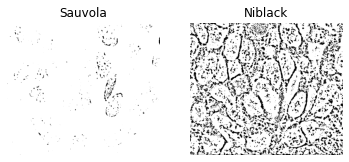

In [55]:
cell = readGRAY('data/01_cell.png')
show_diff(
    test_sau(cell, k=0.1, kernerl=(25, 25)),
    cell_nib, msg="Sauvola", msg_2 = "Niblack"
)

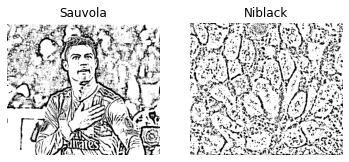

In [56]:
cr = readGRAY('data/01_cr.png')
show_diff(
    test_sau(cr, k=0.1, kernerl=(25, 25)),
    cell_nib, msg="Sauvola", msg_2 = "Niblack"
)

0.12012012012012012
0.24024024024024024
0.36036036036036034
0.4804804804804805
0.6006006006006006
0.7207207207207207
0.8408408408408409
0.960960960960961


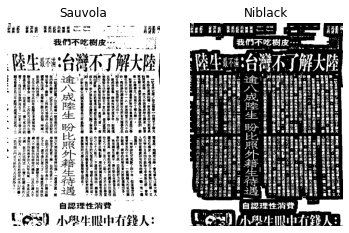

In [57]:
book = readGRAY('data/book.jpg')
show_diff(
    test_sau(book, k=0.1, kernerl=(25, 25)),
    niblack(book, k = 0.1, win = (25, 25))
    , msg="Sauvola", msg_2 = "Niblack"
)

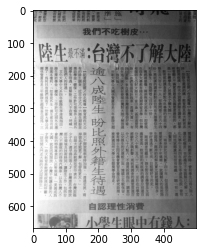

In [58]:
book_gray = readGRAY('data/book.jpg')
show_gray(book_gray)